In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
from ggmodel.graphmodel import GraphModel, concatenate_graph_specs
from ggmodel.validation import score_model, plot_diagnostic

from data_utils.database import select_dataset
from data_utils.utils import get_X_y_from_data, data_dict_from_df_tables
from models.landuse.BE2 import model_dictionnary

import pandas as pd
import numpy as np

/home/simon/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:25: UserWarning: Module ggmodel_dev was already imported from /home/simon/anaconda3/lib/python3.7/site-packages/ggmodel_dev/__init__.py, but /home/simon/GreenGrowthInstitute/GraphModels is being added to sys.path
  from pkg_resources import parse_version  # type: ignore


# Model developement notebook

The goal of this notebook is to develop and improve the landuse model.

Remarks:

- comment 1
- comment 2
- comment 3

## Data

In [50]:
def prepare_landuse_model_data():

    df_tables = ['foodbalancesheet_new', 'population', 'crops', 'landuse']

    df_dictionnary = {df_table: select_dataset(df_table) for df_table in df_tables}

    df_dictionnary['foodbalancesheet_new'] = df_dictionnary['foodbalancesheet_new'][~df_dictionnary['foodbalancesheet_new'].Variable.isin(['Domestic supply quantity'])]

    df_dictionnary['foodbalancesheet_new'] = df_dictionnary['foodbalancesheet_new'].drop(columns=['group']) # for now only crop is considered
    
    data_dict = data_dict_from_df_tables([df for _, df in df_dictionnary.items()])

    data_dict['CL_baseline'] = data_dict['CL']
    data_dict['IL_baseline'] = data_dict['IL']
    data_dict['FL_baseline'] = data_dict['FL']
    data_dict['R_rate'] = pd.Series(data=0, index=data_dict['CL_baseline'].index)
    data_dict['CL_corr_coef'] = pd.Series(data=1.4, index=data_dict['CL_baseline'].index)

    def preprocess_dict_item(key, value):

        return (
            value.fillna(0)
        )

    
    data_dict = {k: preprocess_dict_item(k, v) for k, v in data_dict.items()}
    data_dict['CYi'] = data_dict['CYi'].replace(0, np.nan)
    return data_dict

data_dict = prepare_landuse_model_data()

In [51]:
ISO_data_dict = {k: v.loc[['FRA', 'HUN', 'DEU', 'NLD', 'BEL', 'CHE', 'BRA', 'SEN'], [2016, 2017, 2018], :] for k, v in data_dict.items()}


## Model

In [52]:
for model_name, model in model_dictionnary.items():
    print(model)
    try:
        X, y_true = get_X_y_from_data(model, ISO_data_dict)
        print(score_model(model, X, y_true))
    except Exception as e:
        print(e)



FPi
TCLDi
         r2  correlation          rmse Variable
0  0.043805     0.211274  4.472898e+08      FPi
1  0.932502     0.965834  2.458636e+11    TCLDi

FPi
TCLDi
         r2  correlation          rmse Variable
0  0.043805     0.211274  4.472898e+08      FPi
1  0.932502     0.965834  2.458636e+11    TCLDi

FPi
         r2  correlation          rmse Variable
0  0.043805     0.211274  4.472898e+08      FPi

IL
FL
    r2  correlation  rmse Variable
0  1.0          1.0   0.0       IL
1  1.0          1.0   0.0       FL

Empty DataFrame
Columns: []
Index: []

FL
IL
CL
TCLDi
FPi
         r2  correlation          rmse Variable
0  0.996999     0.999990  8.038138e+07       FL
1 -5.329825     0.835806  4.779927e+05       IL
2  0.797699     0.995561  8.088528e+07       CL
3  0.932502     0.965834  2.458636e+11    TCLDi
4  0.043805     0.211274  4.472898e+08      FPi


## Scenario

In [53]:
from ggmodel.projection import *


def run_BE2_projection(data_dict):
    data_dict = data_dict.copy()
    
    projection_dict = {
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SSRi': lambda x: apply_itemized_ffill_projection(x),
        'SVi': lambda x: apply_itemized_ffill_projection(x),
        'RDi': lambda x: apply_itemized_ffill_projection(x),
        'NFDi': lambda x: apply_itemized_ffill_projection(x),
        'FEi': lambda x: apply_itemized_ffill_projection(x),
        'FIi': lambda x: apply_itemized_ffill_projection(x),
        'PDi': lambda x: apply_itemized_ffill_projection(x),
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SDi': lambda x: apply_itemized_ffill_projection(x),
        'TLA': lambda x: apply_ffill_projection(x),
        'CL_baseline': lambda x: apply_ffill_projection(x),
        'IL_baseline': lambda x: apply_ffill_projection(x),
        'FL_baseline': lambda x: apply_ffill_projection(x),
        'Pop': lambda x: apply_ffill_projection(x),
        'CL_corr_coef': lambda x: apply_ffill_projection(x),
     }
     
    
    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    return data_dict


def run_BE2_scenario(data_dict, FDKGi_target=1, FLOi_target=1, CYi_target=1, R_rate=1):

    data_dict = data_dict.copy()

    projection_dict = {
        'CYi': lambda x: apply_itemized_percent_target_projection(x, CYi_target),
        'FDKGi': lambda x: apply_itemized_percent_target_projection(x, FDKGi_target),
        'FLOi': lambda x: apply_itemized_percent_target_projection(x, FLOi_target),
        'R_rate': lambda x: apply_constant_projection(x, R_rate)
    }

    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])


    results = model_dictionnary['BE2_model'].run(data_dict)

    results['CL_baseline'] = pd.Series(results['CL'].loc[:, 2018].values[0], index=results['CL'].index)

    
    results = model_dictionnary['BE2_model'].run(results)

    return results

In [59]:
%%time

ISO = 'HUN'
data_dict_filtered = {k: v.loc[ISO, 2000:] for k, v in data_dict.items()}

proj_data_dict = run_BE2_projection(data_dict_filtered)

s_1 = run_BE2_scenario(proj_data_dict, FDKGi_target=0.9, FLOi_target=0.8, CYi_target=1.1, R_rate=120)
s_2 = run_BE2_scenario(proj_data_dict, FDKGi_target=0.5, FLOi_target=0.5, CYi_target=1.1, R_rate=120)
s_3 = run_BE2_scenario(proj_data_dict, FDKGi_target=1.5, FLOi_target=1.5, CYi_target=1.1, R_rate=120)

CPU times: user 3.56 s, sys: 8.54 ms, total: 3.57 s
Wall time: 3.56 s


In [60]:
s_1['CYi'].loc[:, 2050, :].dropna()

ISO  Item                            
HUN  Almonds, with shell                   4654.1
     Anise, badian, fennel, coriander     16088.0
     Apples                              234503.5
     Apricots                             31276.3
     Asparagus                            43544.6
                                           ...   
     Walnuts, with shell                  11753.5
     Watermelons                         386469.6
     Wheat                                56368.4
     Berries nes                          39276.6
     Fruit, pome nes                      85485.4
Name: CYi, Length: 92, dtype: float64

<AxesSubplot:xlabel='ISO,Year'>

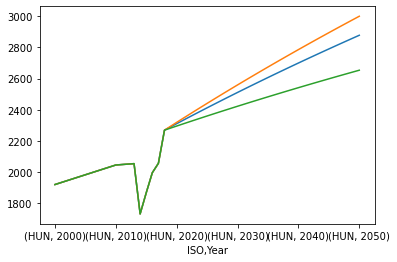

In [61]:
s_1['FL_RF'].plot()
s_2['FL_RF'].plot()
s_3['FL_RF'].plot()